In [1]:
%matplotlib widget
import numpy as np
import obspy
from hydrophone_data_processing import load, useful_variables, plotting, signal_processing
import scipy.signal as signal
import matplotlib.pyplot as plt
import initial_event_times as iet

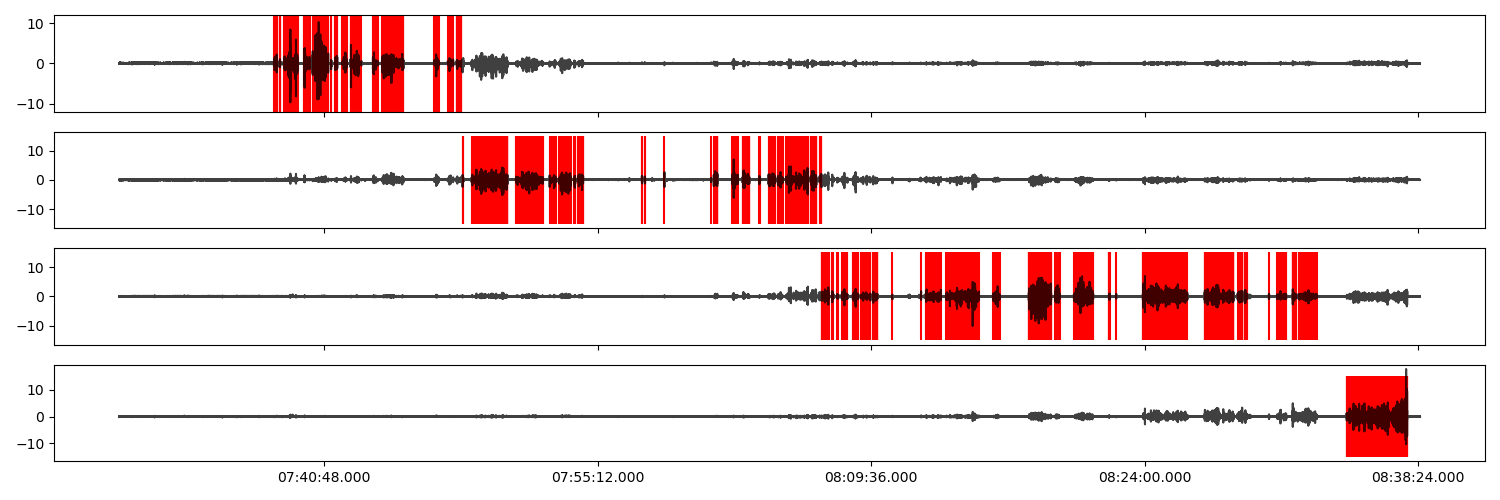

In [2]:
fig, axes = plt.subplots(4, 1, figsize=(15, 5), sharex=True)

for n, ax in enumerate(axes):
    data = iet.day141_snapshot[n+2]
    ax.plot(data.times('matplotlib'), data.data, color='black', alpha=0.75)
    h_id = list(iet.detector_data.keys())[n]
    # ax.vlines(x=get_event_times('h3'), ymin=-15, ymax=15, color='red')
    ax.vlines(x=iet.get_event_times(h_id), ymin=-15, ymax=15, color='red')


axes[0].set_ylim(-12, 12)
axes[-1].xaxis.set_major_formatter(plotting.PrecisionDateFormatter("%H:%M:%S.{ms}"))
fig.tight_layout()

In [3]:
iet.df

,index,event_times (mpl),event_times (abs),hphone_idx,ones,event_times
0,0,18037.318174,2019-05-21T07:38:10.208000Z,h3,1,2019-05-21 07:38:10.208000+00:00
1,1,18037.318189,2019-05-21T07:38:11.526000Z,h3,1,2019-05-21 07:38:11.526000+00:00
2,2,18037.318203,2019-05-21T07:38:12.754000Z,h3,1,2019-05-21 07:38:12.754000+00:00
3,3,18037.318207,2019-05-21T07:38:13.074000Z,h3,1,2019-05-21 07:38:13.074000+00:00
4,4,18037.318219,2019-05-21T07:38:14.141000Z,h3,1,2019-05-21 07:38:14.141000+00:00
...,...,...,...,...,...,...
1997,300,18037.359564,2019-05-21T08:37:46.291000Z,h6,1,2019-05-21 08:37:46.291000+00:00
1998,301,18037.359570,2019-05-21T08:37:46.891000Z,h6,1,2019-05-21 08:37:46.891000+00:00
1999,302,18037.359578,2019-05-21T08:37:47.564000Z,h6,1,2019-05-21 08:37:47.564000+00:00
2000,303,18037.359589,2019-05-21T08:37:48.513000Z,h6,1,2019-05-21 08:37:48.513000+00:00


In [4]:
import obspy.signal.trigger as trigger
trigger.aic_simple

<function obspy.signal.trigger.aic_simple(a)>

87

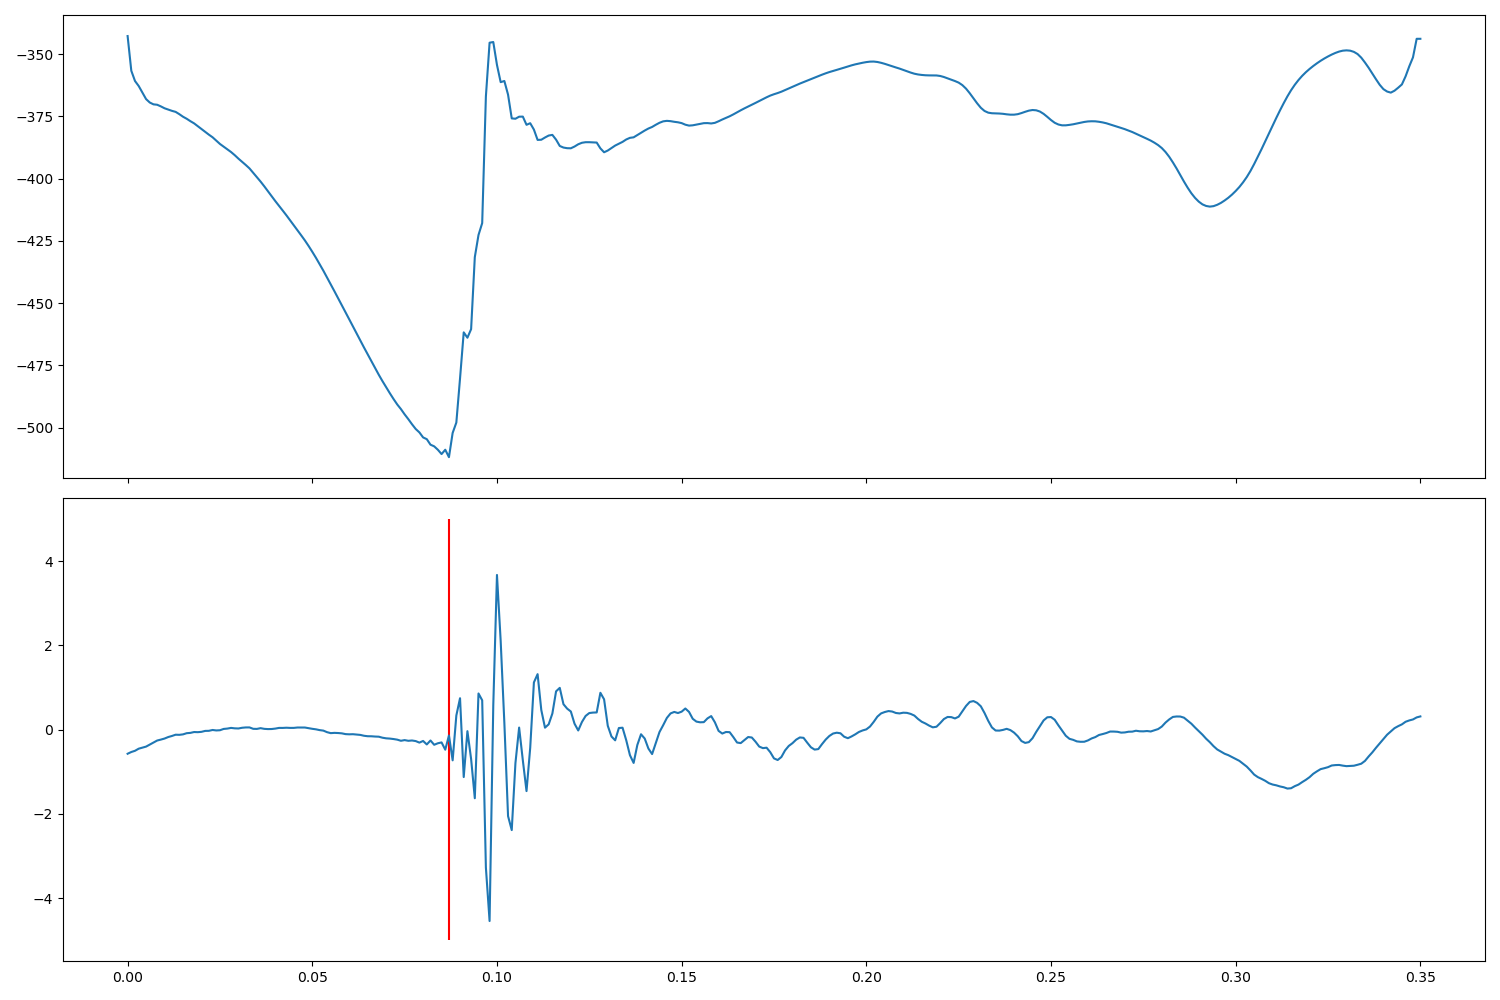

In [26]:
event_id = 94
hydrophone = 'h3'

event = iet.get_event_window(iet.df['event_times (abs)'].iloc[event_id], hydrophone=hydrophone)
event_raw = iet.get_event_window_raw(iet.df['event_times (abs)'].iloc[event_id], hydrophone=hydrophone)

fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

aic = trigger.aic_simple(event_raw)


t = event_raw.times()

aic_arrival = t[aic.argmin()]

ax[0].plot(t, aic)
ax[1].plot(t, event_raw)

ax[1].vlines(x=aic_arrival, ymin=-5, ymax=5, color='red')

fig.tight_layout()
aic.argmin()

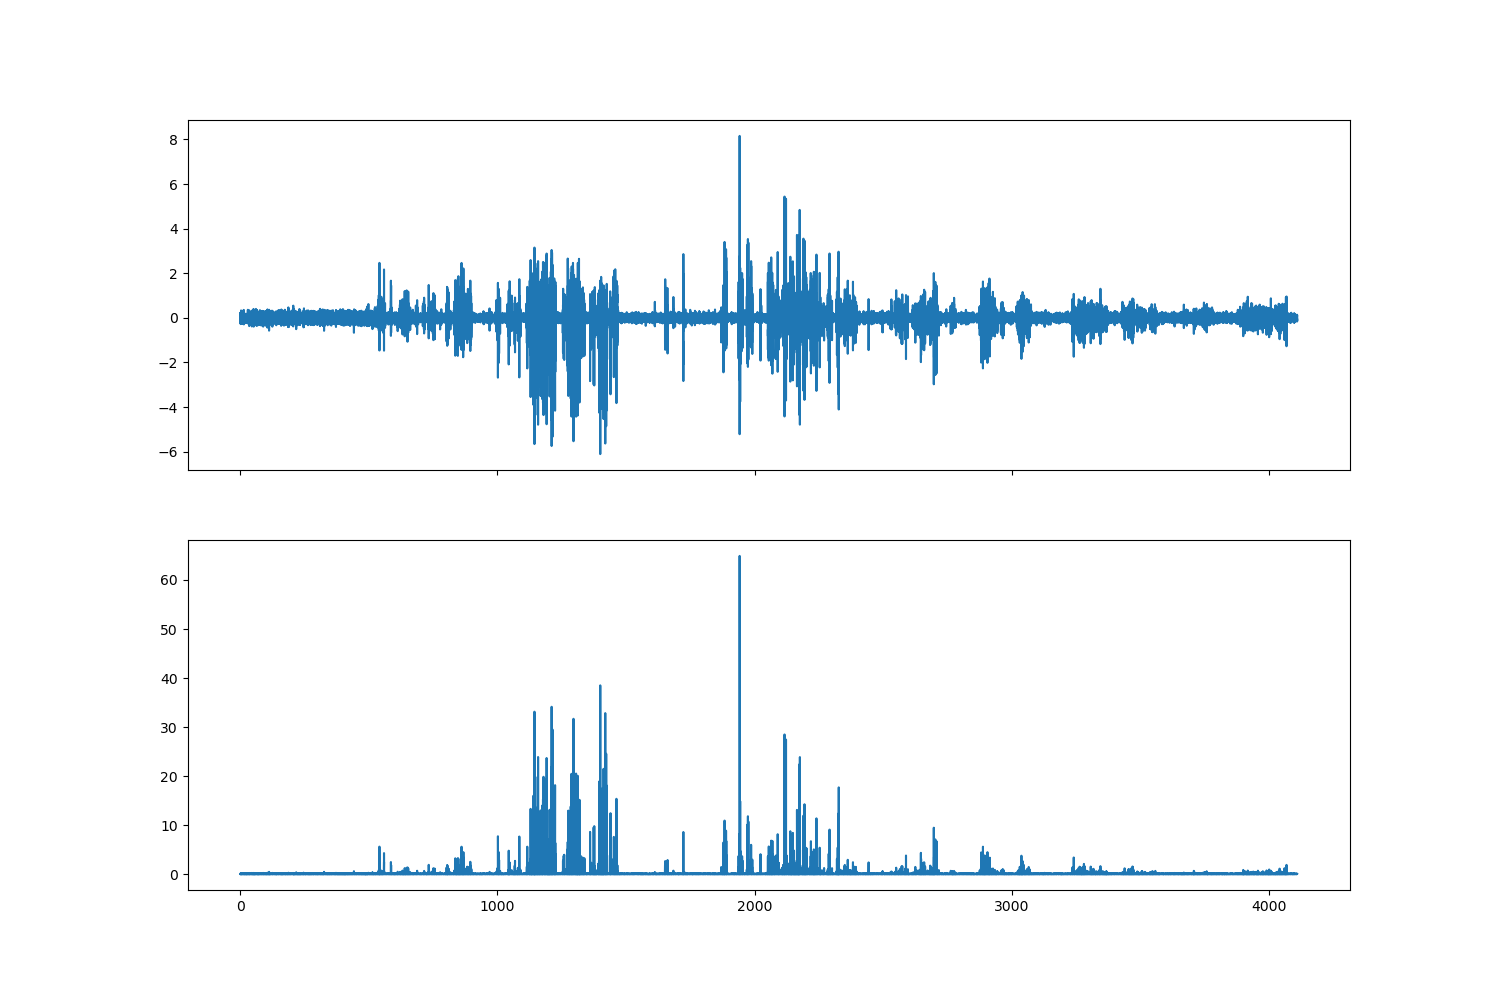

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
ax[1].plot(h3t, h3sq)

ax[0].plot(iet.day141_raw[3].times(), iet.day141_raw[3].data-iet.day141_raw[3].data.mean())

7F.A00.04.GDH | 2019-05-21T07:30:00.000000Z - 2019-05-21T08:38:30.000000Z | 1000.0 Hz, 4110001 samples